<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Sigma-sweep" data-toc-modified-id="Sigma-sweep-1.1.0.1"><span class="toc-item-num">1.1.0.1&nbsp;&nbsp;</span>Sigma sweep</a></span></li><li><span><a href="#Plot-mean-success-vs-sigma" data-toc-modified-id="Plot-mean-success-vs-sigma-1.1.0.2"><span class="toc-item-num">1.1.0.2&nbsp;&nbsp;</span>Plot mean success vs sigma</a></span></li><li><span><a href="#Plot-mean-persistent-time-vs-sigma" data-toc-modified-id="Plot-mean-persistent-time-vs-sigma-1.1.0.3"><span class="toc-item-num">1.1.0.3&nbsp;&nbsp;</span>Plot mean persistent time vs sigma</a></span></li></ul></li></ul></li><li><span><a href="#General-parameters" data-toc-modified-id="General-parameters-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>General parameters</a></span></li></ul></li><li><span><a href="#Persistent-time" data-toc-modified-id="Persistent-time-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Persistent time</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>An example</a></span></li><li><span><a href="#Systematic-variation" data-toc-modified-id="Systematic-variation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Systematic variation</a></span><ul class="toc-item"><li><span><a href="#Changing-the-persistent-time-with-gain" data-toc-modified-id="Changing-the-persistent-time-with-gain-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Changing the persistent time with gain</a></span></li><li><span><a href="#Changing-the-persistent-time-with-the-value-of-tau_z" data-toc-modified-id="Changing-the-persistent-time-with-the-value-of-tau_z-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Changing the persistent time with the value of tau_z</a></span></li><li><span><a href="#Variations-in-both" data-toc-modified-id="Variations-in-both-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Variations in both</a></span></li></ul></li><li><span><a href="#Noise" data-toc-modified-id="Noise-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Noise</a></span></li></ul></li><li><span><a href="#Save-the-figures" data-toc-modified-id="Save-the-figures-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Save the figures</a></span></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from network import Protocol, Network, NetworkManager
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## Functions

#### Sigma sweep

In [2]:
def run_sigma_sweep(sigma_number, samples, sigma_max, manager, T_persistence=0.050, tau_z_pre=0.025):
    
    hypercolumns = 1
    minicolumns = 5
    n_patterns = minicolumns
    
    dt = 0.001
    tau_s = 0.010
    tau_a = 0.250
    g_I = 3.0
    g_a = 2.0
    G = 50.0
    
    sigma_out = 0.0
    tau_z_pre = tau_z_pre 
    tau_z_post = 0.005

    # Training protocol
    training_times_base = 0.100
    training_times = [training_times_base for i in range(n_patterns)]
    ipi_base = 0.000
    inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
    inter_sequence_interval = 0.0
    resting_time = 0.0
    epochs = 1
    T_persistence = 0.100

    # Manager properties
    values_to_save = ['o']

    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)

    
    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)
    
    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
    
    tau_s = manager.nn.tau_s
    T_recall = 2 * T_persistence * manager.nn.minicolumns
    T_cue = 2 * tau_s
    nr = manager.canonical_network_representation
    n_patterns = len(nr)

    sigma_vector = np.linspace(0.05, sigma_max, num=sigma_number)

    successes_collection = np.zeros((sigma_number, samples))
    persistent_times_collection = {index: [] for index in range(sigma_number)}
    sequence_collection = {index: [] for index in range(sigma_number)}

    for index, sigma in enumerate(sigma_vector):
        manager.nn.sigma_out = sigma
        manager.nn.sigma_in = sigma * np.sqrt(2 / tau_s)
        for sample in range(samples):
            aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove,
                                              reset=True, empty_history=True)
            success, pattern_sequence, persistent_times, timings = aux
            successes_collection[index, sample] = success
            persistent_times_collection[index].append(persistent_times[:n_patterns])
            sequence_collection[index].append(pattern_sequence)

    results_dic = {'manager': manager, 'sigma_vector': sigma_vector, 'success': successes_collection,
                   'persistent times': persistent_times_collection, 'sequences': sequence_collection,
                   'T_persistence': T_persistence}

    return results_dic

#### Plot mean success vs sigma

In [23]:
def plot_mean_success_vs_sigma(results_dictionary, n_samples, index=0, label=0, ax=None, add_zero_axis=False, 
                               legend=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    successes_collection = results_dictionary['success']
    sigma_vector = results_dictionary['sigma_vector']

    std = successes_collection.std(axis=1)
    mean_success = successes_collection.mean(axis=1)
    ci_low, ci_upp = sm.stats.proportion_confint(mean_success * n_samples, n_samples, alpha=0.05, method='normal')

    # Plot the mean
    ax.plot(sigma_vector, mean_success, 'o-', lw=lw, ms=ms, color=colors[index], label=label)
    
    if False:
        # Plot sigma05
        sigma09_arg = np.where(mean_success <= 0.9)[0]
        if sigma09_arg.size > 0:
            sigma09 = sigma_vector[sigma09_arg[0]]
            ax.plot(sigma09, 0.9, '*', ms=(ms + 20), color='black')

        sigma01_arg = np.where(mean_success <= 0.1)[0]
        if sigma01_arg.size > 0:
            sigma01 = sigma_vector[sigma01_arg[0]]
            ax.plot(sigma01, 0.1, '*', ms=(ms + 20), color='black')
    
    # Plot the interval
    low = ci_low
    low[low < 0.0] = 0.0
    high = ci_upp
    ax.fill_between(sigma_vector, low, high, color=colors[index], alpha=alpha_graph)
    
    if add_zero_axis:
        ax.axhline(0, ls='--', color='gray')
        ax.axvline(0, ls='--', color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel('Success rate')
    
    if legend:
        ax.legend(frameon=False)

    return ax

#### Plot mean persistent time vs sigma

In [4]:
def plot_persistent_time_vs_sigma(results_dictionary, index=0, label=0, ax=None, single=True, add_zero_axis=False):

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    persistent_times = results_dictionary['persistent times'] 
    sigma_vector = results_dictionary['sigma_vector']
    T_persistence = results_dictionary['T_persistence']
    mean_persistent = np.zeros(sigma_vector.size)
    low = np.zeros(sigma_vector.size)
    high = np.zeros(sigma_vector.size)
    std = np.zeros(sigma_vector.size)
    
    for sigma_index in range(sigma_vector.size):
        flatted = [item for l in persistent_times[sigma_index] for item in l[1:-1]]
        mean_persistent[sigma_index] = np.mean(flatted)
        std[sigma_index] = np.std(flatted)
        low[sigma_index] = np.percentile(flatted, 25)
        high[sigma_index] = np.percentile(flatted, 75)

    ax.plot(sigma_vector, mean_persistent, 'o-', lw=lw, ms=ms, color=colors[index] , label=label)
    ax.fill_between(sigma_vector, low, high,color=colors[index], alpha=alpha_graph)
    if add_zero_axis:
        ax.axhline(0, ls='--',color='gray')
        ax.axvline(0, ls='--',color='gray')
    
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$T_{persistence} (s)$')

    if single:
        ax.axhline(T_persistence, ls='--', color=colors[index], label=r'$T_{base}$' )
        ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
        ax.legend(frameon=False)
    
    return ax

## General parameters

In [5]:
%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

epsilon = 1e-7
vmin = -6.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 3.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

# Persistent time

## An example

In [6]:
%%time

sigma_out = 0.1
tau_z_pre = 0.100
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o', 'i', 'z_pre', 's']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

CPU times: user 64 ms, sys: 20 ms, total: 84 ms
Wall time: 60.9 ms


success 0.0
pattern sequence [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 16, 17, 18, 19]
times [0.034, 0.089, 0.016, 0.11, 0.056, 0.022, 0.07100000000000001, 0.013000000000000001, 0.032, 0.01, 0.05, 0.048, 0.074, 0.068, 0.01, 0.029, 0.068, 0.023, 0.018000000000000002, 0.08700000000000001, 0.061, 0.012, 0.054, 0.012, 0.047, 0.047, 0.027, 0.011, 0.081, 0.069, 0.06, 0.011, 0.013000000000000001, 0.08, 0.012, 0.092, 0.017, 0.011, 0.158]
T_calculated 0.04354054054054054


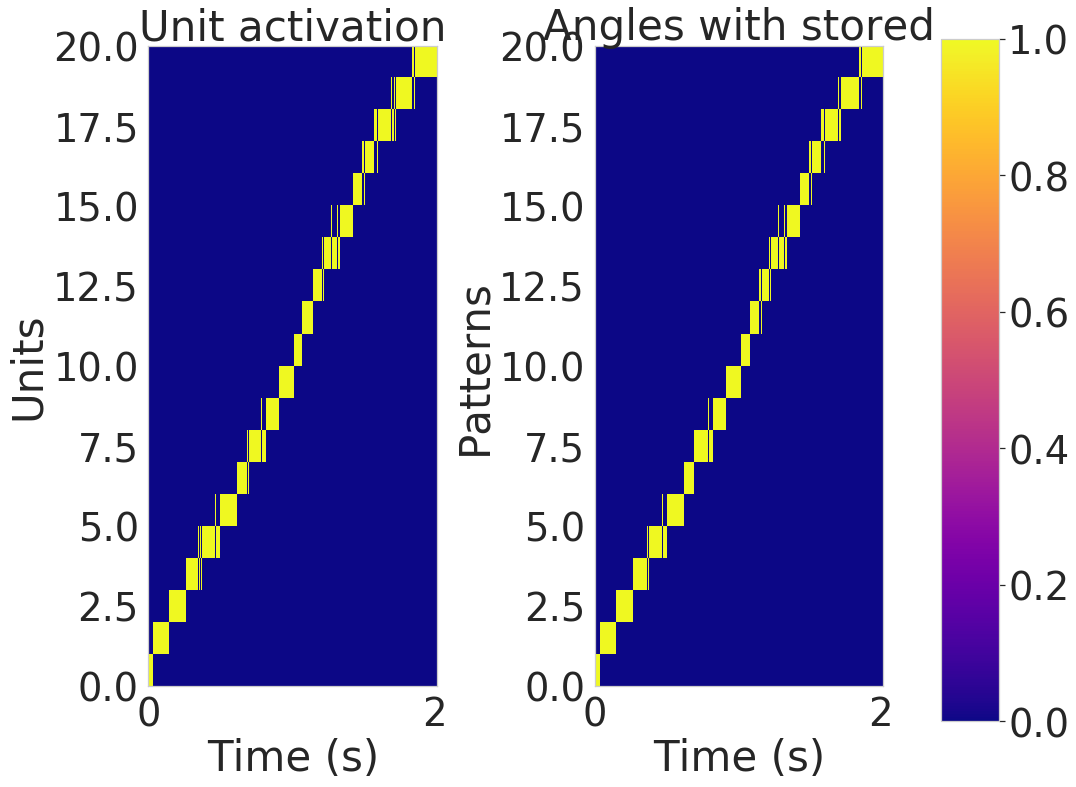

In [7]:
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

T_cue = 1.0 * manager.nn.tau_s
T_recall = 4.0 * T_persistence * n_patterns + T_cue

# Success
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

print('success', success)
print('pattern sequence', pattern_sequence)
print('times', persistent_times)
print('T_calculated', np.mean(persistent_times[1:-1]))
plot_network_activity_angle(manager, time_y=False);

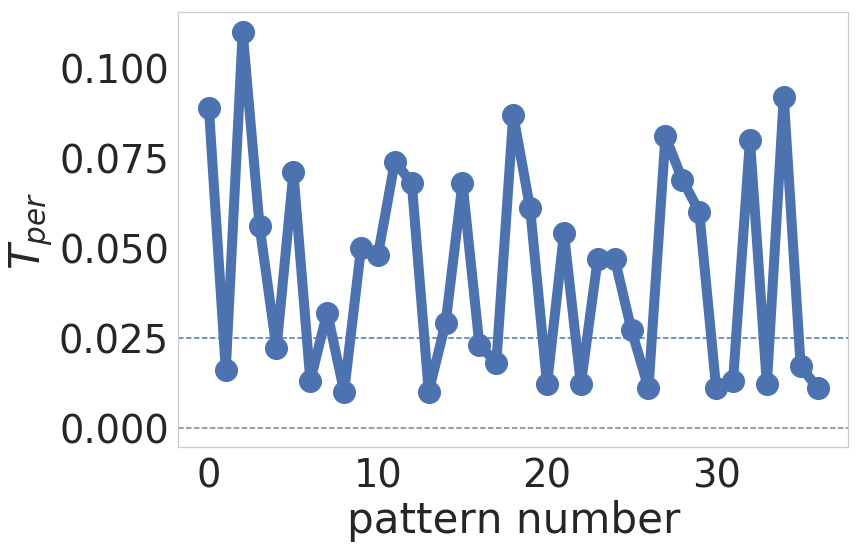

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

index = 0
ax.plot(persistent_times[1:-1], 'o-', lw=lw, ms=ms, color=colors[index])
ax.axhline(T_persistence, ls='--', color=colors[index])
ax.set_xlabel('pattern number')
ax.set_ylabel(r'$T_{per}$')

ax.axhline(0, ls='--', color='gray')

## Systematic variation

### Changing the persistent time with gain

In [9]:
%%time

sigma_out = 0.0
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

CPU times: user 60 ms, sys: 8 ms, total: 68 ms
Wall time: 52.7 ms


In [10]:
%%time

T_per_set = [0.025, 0.050, 0.075, 0.100]
persistent_times_list = []

for T_persistence in T_per_set:
    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

    T_cue = 1.0 * manager.nn.tau_s
    T_recall = 2.0 * T_persistence * n_patterns + T_cue

    # Success
    nr = representation.network_representation
    aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
    success, pattern_sequence, persistent_times, timings = aux
    persistent_times_list.append(persistent_times[1:-1])

CPU times: user 2.32 s, sys: 8 ms, total: 2.33 s
Wall time: 2.14 s


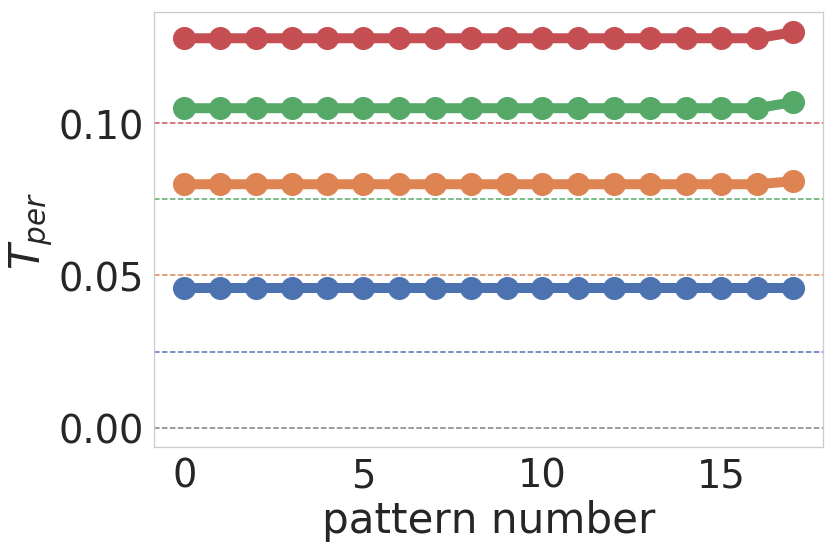

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

for index, x in enumerate(persistent_times_list):
    ax.plot(x, 'o-', lw=lw, ms=ms, color=colors[index])
    ax.axhline(T_per_set[index], ls='--', color=colors[index])

ax.set_xlabel('pattern number')
ax.set_ylabel(r'$T_{per}$')

ax.axhline(0, ls='--', color='gray')

In [12]:
for index, x in enumerate(persistent_times_list):
    T_mean = np.mean(x[1:-1])
    T_diff = T_mean - T_per_set[index]
    print('T_per_encoded', T_per_set[index])
    print('T_diff', T_diff * 1000.0, ' ms')
    print('------------')

T_per_encoded 0.025
T_diff 20.999999999999996  ms
------------
T_per_encoded 0.05
T_diff 30.0  ms
------------
T_per_encoded 0.075
T_diff 30.0  ms
------------
T_per_encoded 0.1
T_diff 27.999999999999996  ms
------------


In [13]:
%%time
T_per_set = [0.100, 0.250, 0.500, 0.750, 1.0]
persistent_times_list = []

for T_persistence in T_per_set:
    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

    T_cue = 1.0 * manager.nn.tau_s
    T_recall = 2.0 * T_persistence * n_patterns + T_cue

    # Success
    nr = representation.network_representation
    aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
    success, pattern_sequence, persistent_times, timings = aux
    persistent_times_list.append(persistent_times[1:-1])

CPU times: user 25.4 s, sys: 312 ms, total: 25.7 s
Wall time: 21.7 s


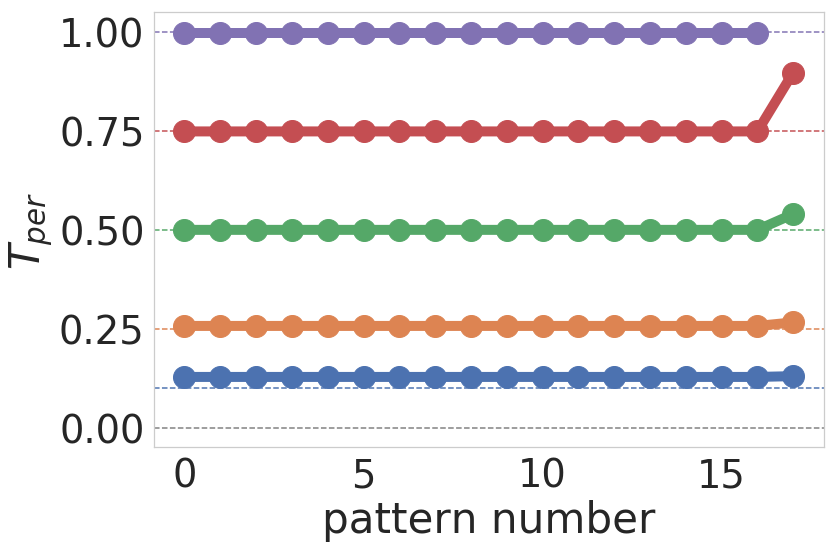

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

for index, x in enumerate(persistent_times_list):
    ax.plot(x, 'o-', lw=lw, ms=ms, color=colors[index])
    ax.axhline(T_per_set[index], ls='--', color=colors[index])

ax.set_xlabel('pattern number')
ax.set_ylabel(r'$T_{per}$')

ax.axhline(0, ls='--', color='gray');

In [15]:
for index, x in enumerate(persistent_times_list):
    T_mean = np.mean(x[1:-1])
    T_diff = T_mean - T_per_set[index]
    print('T_per_encoded', T_per_set[index])
    print('T_diff', T_diff * 1000.0, ' ms')
    print('------------')

T_per_encoded 0.1
T_diff 27.999999999999996  ms
------------
T_per_encoded 0.25
T_diff 7.000000000000006  ms
------------
T_per_encoded 0.5
T_diff 0.0  ms
------------
T_per_encoded 0.75
T_diff -1.0000000000000009  ms
------------
T_per_encoded 1.0
T_diff -2.000000000000335  ms
------------


For larger values of T_persistence the value becomes 

### Changing the persistent time with the value of tau_z

In [16]:
%%time

tau_z_set = [0.025, 0.050, 0.075, 0.100]
persistent_times_list = []


sigma_out = 0.0
tau_z_pre = 0.050
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 20
n_patterns = minicolumns

# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.000
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1
T_persistence = 0.025

# Manager properties
values_to_save = ['o']

for tau_z_pre in tau_z_set:

    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)

    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

    T_cue = 1.0 * manager.nn.tau_s
    T_recall = 5.0 * T_persistence * n_patterns + T_cue

    # Success
    nr = representation.network_representation
    aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
    success, pattern_sequence, persistent_times, timings = aux
    persistent_times_list.append(persistent_times[1:minicolumns - 1])

CPU times: user 3.04 s, sys: 44 ms, total: 3.09 s
Wall time: 2.26 s


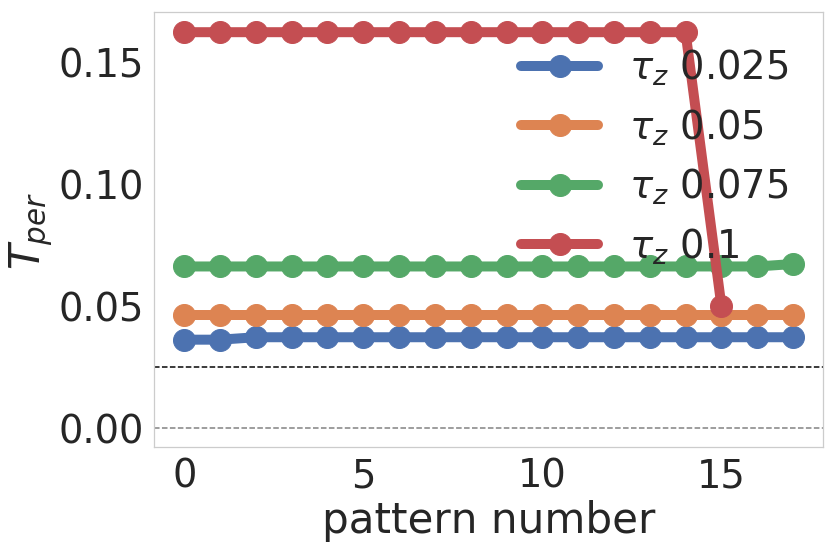

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

for index, x in enumerate(persistent_times_list):
    ax.plot(x, 'o-', lw=lw, ms=ms, color=colors[index], label=r'$\tau_z$ ' + str(tau_z_set[index]))
ax.axhline(T_persistence, ls='--', color='black')

ax.set_xlabel('pattern number')
ax.set_ylabel(r'$T_{per}$')

ax.legend(frameon=False)
ax.axhline(0, ls='--', color='gray');

In [18]:
for index, x in enumerate(persistent_times_list):
    T_mean = np.mean(x[1:-1])
    T_diff = T_mean - T_persistence
    print('T_per_encoded', T_persistence)
    print('T_diff', T_diff * 1000.0, ' ms')
    print('------------')

T_per_encoded 0.025
T_diff 11.937499999999996  ms
------------
T_per_encoded 0.025
T_diff 20.999999999999996  ms
------------
T_per_encoded 0.025
T_diff 41.0  ms
------------
T_per_encoded 0.025
T_diff 136.99999999999997  ms
------------


### Variations in both

## Noise 

In [19]:
%%time

tau_z_pre_set = [0.025, 0.050, 0.075, 0.100]
# tau_z_pre_set = [0.025]
T_persistence = 0.050
results_dictionary_collection_tp = {}
sigma_number = 20
samples = 500
sigma_max = 1.0

for tau_z_pre in tau_z_pre_set:
    print(tau_z_pre)
    results_dictionary= run_sigma_sweep(sigma_number, samples, sigma_max, manager, 
                                        T_persistence=T_persistence, tau_z_pre=tau_z_pre)  
    results_dictionary_collection_tp[tau_z_pre] = results_dictionary

0.025
0.05
0.075
0.1
CPU times: user 1h 4s, sys: 6.1 s, total: 1h 11s
Wall time: 1h 11s


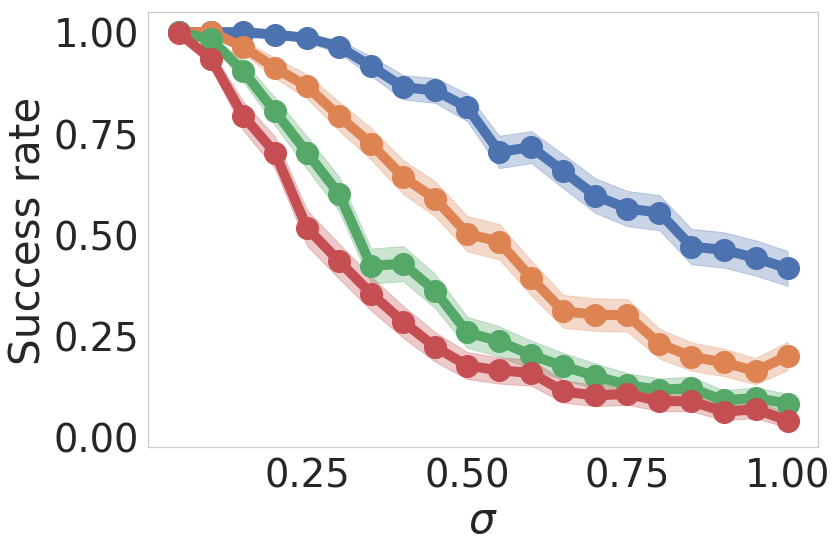

In [24]:
results_dictionary_collection = results_dictionary_collection_tp
ax = None
for index, tau_z_pre in enumerate(tau_z_pre_set):
    label = r'$\tau_{z_{pre}}$ = ' + str(tau_z_pre)
    results_dictionary = results_dictionary_collection[tau_z_pre]
    ax = plot_mean_success_vs_sigma(results_dictionary, n_samples=samples, index=index, label=label, ax=ax)

Text(0, 0.5, '$T_{per}$')

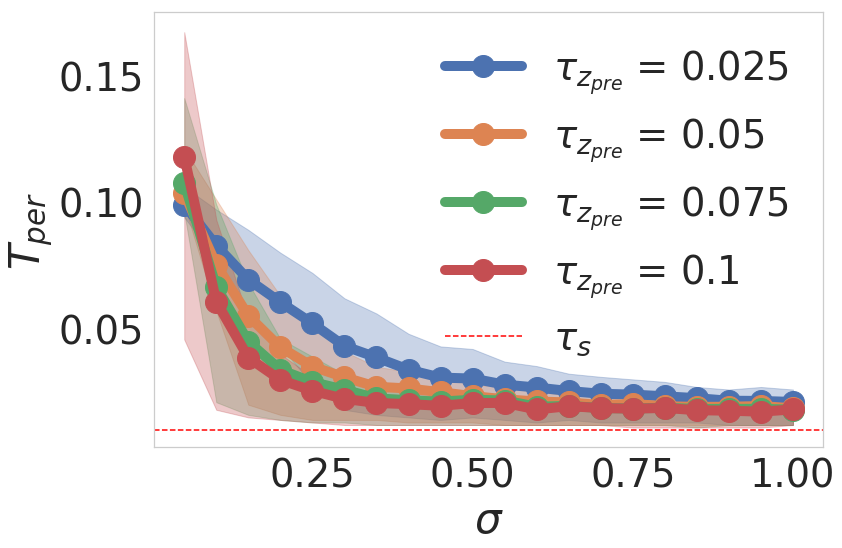

In [25]:
results_dictionary_collection = results_dictionary_collection_tp
ax = None
for index, tau_z_pre in enumerate(tau_z_pre_set):
    label = r'$\tau_{z_{pre}}$ = ' + str(tau_z_pre)
    results_dictionary = results_dictionary_collection[tau_z_pre]
    ax = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax, single=False)

ax.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
ax.legend(frameon=False)
ax.set_ylabel(r'$T_{per}$')

# Save the figures

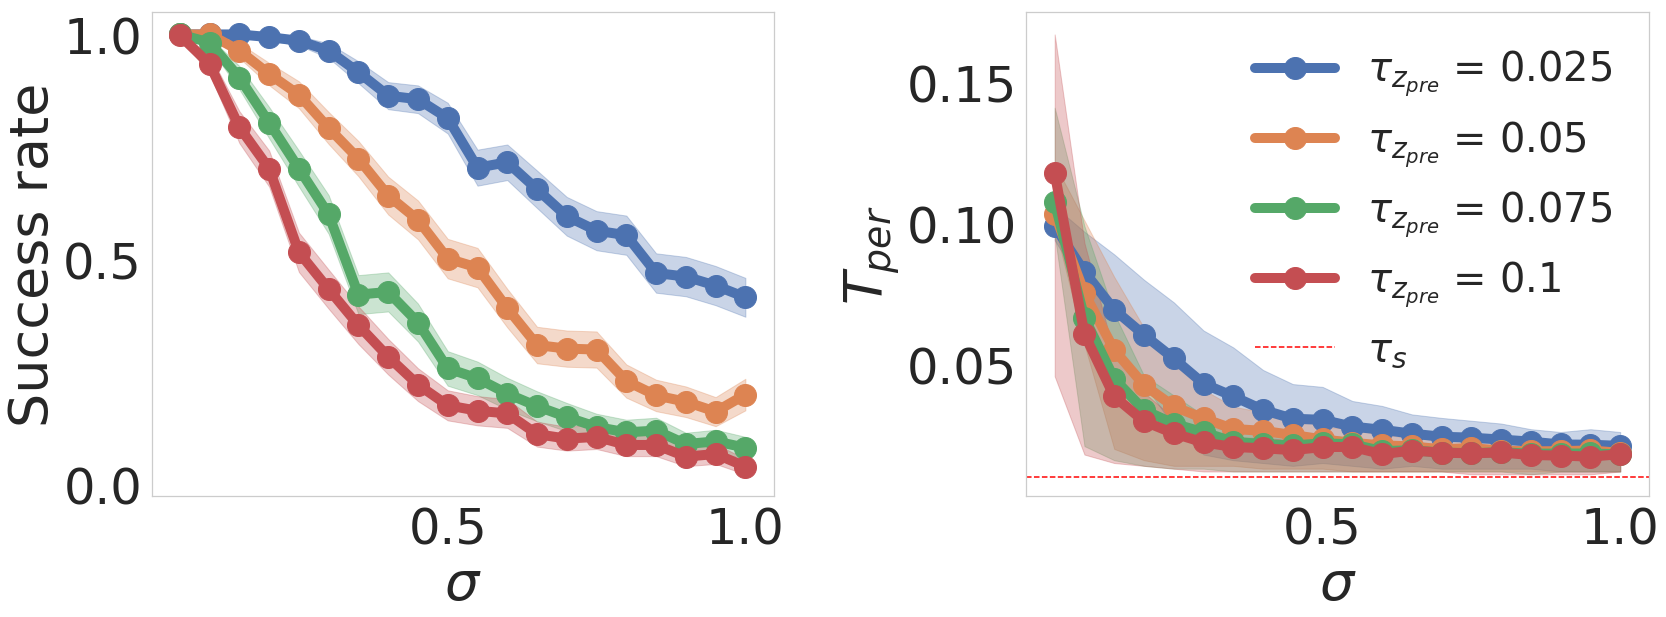

In [43]:
sns.set(font_scale=4.5)
sns.set_style("whitegrid", {'axes.grid': False})


fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
results_dictionary_collection = results_dictionary_collection_tp

for index, tau_z_pre in enumerate(tau_z_pre_set):
    label = r'$\tau_{z_{pre}}$ = ' + str(tau_z_pre)
    results_dictionary = results_dictionary_collection[tau_z_pre]
    ax1 = plot_mean_success_vs_sigma(results_dictionary, n_samples=samples, index=index, label=label, ax=ax1)
    
for index, tau_z_pre in enumerate(tau_z_pre_set):
    label = r'$\tau_{z_{pre}}$ = ' + str(tau_z_pre)
    results_dictionary = results_dictionary_collection[tau_z_pre]
    ax2 = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax2, single=False)

ax2.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
ax2.legend(frameon=False, fontsize=40)
ax2.set_ylabel(r'$T_{per}$')

fig.tight_layout()

directory = '../plot_producers/'
file_name = 'noise_effect' 
format_string = '.svg'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=1000, bbox_inches='tight', transparent=True)

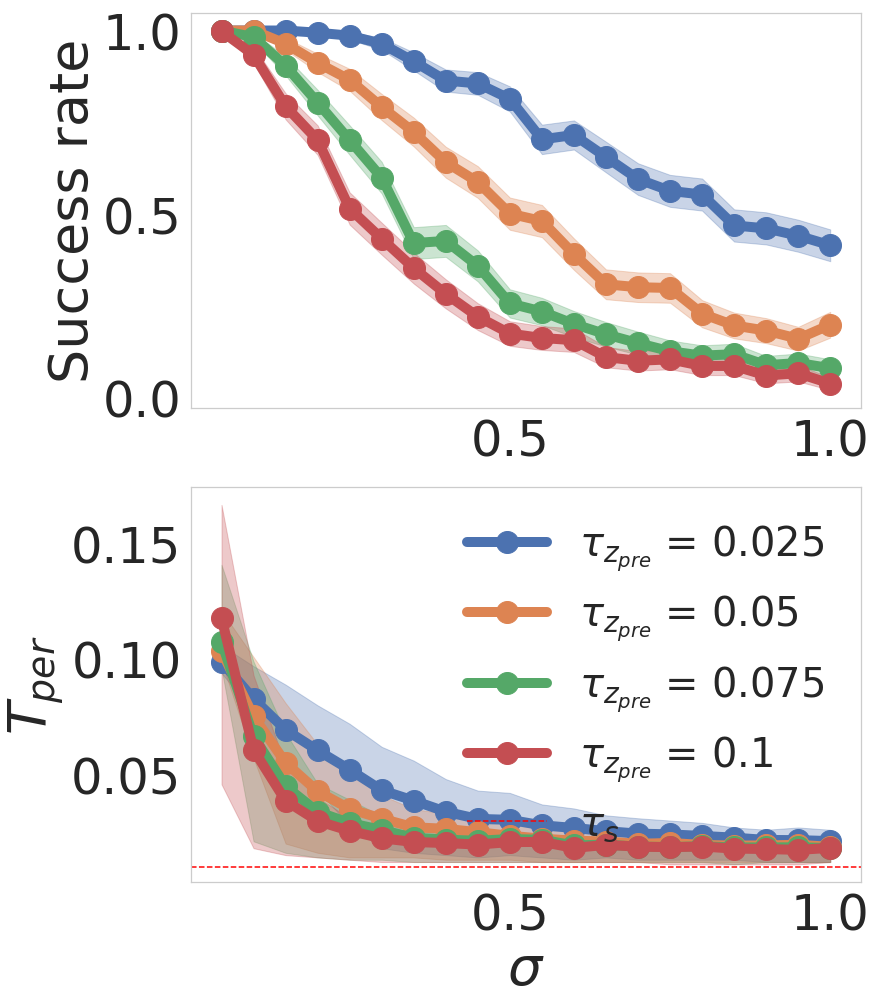

In [49]:
sns.set(font_scale=4.5)
sns.set_style("whitegrid", {'axes.grid': False})


fig = plt.figure(figsize=(12, 16))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
results_dictionary_collection = results_dictionary_collection_tp

for index, tau_z_pre in enumerate(tau_z_pre_set):
    label = r'$\tau_{z_{pre}}$ = ' + str(tau_z_pre)
    results_dictionary = results_dictionary_collection[tau_z_pre]
    ax1 = plot_mean_success_vs_sigma(results_dictionary, n_samples=samples, index=index, label=label, ax=ax1)

ax1.set_xlabel(' ')
for index, tau_z_pre in enumerate(tau_z_pre_set):
    label = r'$\tau_{z_{pre}}$ = ' + str(tau_z_pre)
    results_dictionary = results_dictionary_collection[tau_z_pre]
    ax2 = plot_persistent_time_vs_sigma(results_dictionary, index=index, label=label, ax=ax2, single=False)

ax2.axhline(tau_s, ls='--', color='red', label=r'$\tau_s$')
ax2.legend(frameon=False, fontsize=40)
ax2.set_ylabel(r'$T_{per}$')


directory = '../plot_producers/'
file_name = 'noise_effect2' 
format_string = '.svg'
string_to_save = directory + file_name + format_string
fig.savefig(string_to_save, frameon=False, dpi=1000, bbox_inches='tight', transparent=True)